In [1]:
%cd ..
# move to the root directory of the git

C:\Users\Admin\Documents\GitHub\FLOOD_project


In [2]:
import importlib
import joblib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torch.utils.data import DataLoader

from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.metrics import confusion_mat
from post_processing.plots import plot_test_loss, plot_metrics, plot_sorted

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/model_paths/multiconv_lstm_8hid_4lay_5ker.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


In [7]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


In [8]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 1, 4, 128, 128])
Restored targets Shape: torch.Size([10, 120, 2, 128, 128])


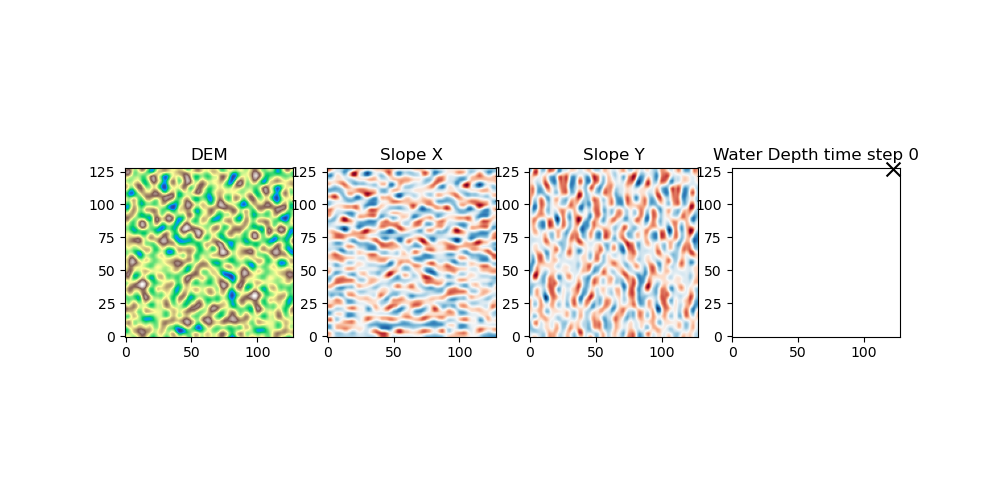

In [9]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 2
input = test_dataset3[numb][0]

axs[0].imshow(input[0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(input[0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(input[0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(input[0][3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Water Depth time step 0')

non_zero_indices = torch.nonzero(input[0, 3])
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
            clip_on = False, clip_box = plt.gca().transData)

In [11]:
# Normalize the inputs and outputs using training dataset, this was done in previous notebook, only need to load the scalers
scaler_x = joblib.load('models/ConvLSTM_model/scalers/scaler_x.joblib')
scaler_y = joblib.load('models/ConvLSTM_model/scalers/scaler_y.joblib')

norm_test1 = normalize_dataset(test_dataset1, scaler_x, scaler_y, test1)
norm_test2 = normalize_dataset(test_dataset2, scaler_x, scaler_y, test2)
norm_test3 = normalize_dataset(test_dataset3, scaler_x, scaler_y, test3)

In [12]:
# Model: has to be the same as in other notebook
model = MultiStepConvLSTM(input_dim = norm_test1[0][0].shape[1],
                          output_dim = norm_test1[0][1].shape[1],
                          hidden_dim = 8, kernel_size = (5, 5), num_layers = 4,
                          batch_first=True, bias=True, return_all_layers = False).to(device)

In [13]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-3): 3 x ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [14]:
# Create the test dataloaders to "feed" data to the model
test1_loader = DataLoader(norm_test1, batch_size = 8, shuffle = False)
test2_loader = DataLoader(norm_test2, batch_size = 8, shuffle = False)
test3_loader = DataLoader(norm_test3, batch_size = 8, shuffle = False)

In [15]:
# load model no avoid training every time notebook is run
model.load_state_dict(torch.load(save_path, map_location = torch.device(device)))

<All keys matched successfully>

In [16]:
test_loss = evaluation_conv_lstm(model, test1_loader, device)
recall1, acc1, f1_1 = confusion_mat(norm_test1, model, scaler_y, device)

In [17]:
test_loss2 = evaluation_conv_lstm(model, test2_loader, device=device)
recall2, acc2, f1_2 = confusion_mat(norm_test2, model, scaler_y, device)

In [18]:
# test_loss3 = evaluation_conv_lstm(model, test3_loader, device=device)
# recall3, acc3, f1_3 = confusion_mat(norm_test3, model, scaler_y, device)

In [19]:
print(f'Test_loss for Water Depth and Discharge:\n'
      f'\t First test dataset: {test_loss :.4f}\n'
      f'\t Second test dataset: {test_loss2 :.4f}\n')
      #f'\t Third test dataset: {test_loss3 :.4f}\n')

print(f'Average Recall for Water Depth:\n'
      f'\t First test dataset: {torch.mean(recall1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(recall2) :.4f}\n')
      #f'\t Third test dataset: {torch.mean(recall3) :.4f}\n')

print(f'Average F1 score for Water Depth:\n'
      f'\t First test dataset: {torch.mean(f1_1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(f1_2) :.4f}\n')
      #f'\t Third test dataset: {torch.mean(f1_3) :.4f}\n')

print(f'Average Accuracy for Water Depth:\n'
      f'\t First test dataset: {torch.mean(acc1) :.4f}\n'
      f'\t Second test dataset: {torch.mean(acc2) :.4f}\n')
      #f'\t Third test dataset: {torch.mean(acc3) :.4f}')

Test_loss for Water Depth and Discharge:
	 First test dataset: 0.0012
	 Second test dataset: 0.0024

Average Recall for Water Depth:
	 First test dataset: 0.7650
	 Second test dataset: 0.2659

Average F1 score for Water Depth:
	 First test dataset: 0.7054
	 Second test dataset: 0.2902

Average Accuracy for Water Depth:
	 First test dataset: 0.9173
	 Second test dataset: 0.7948



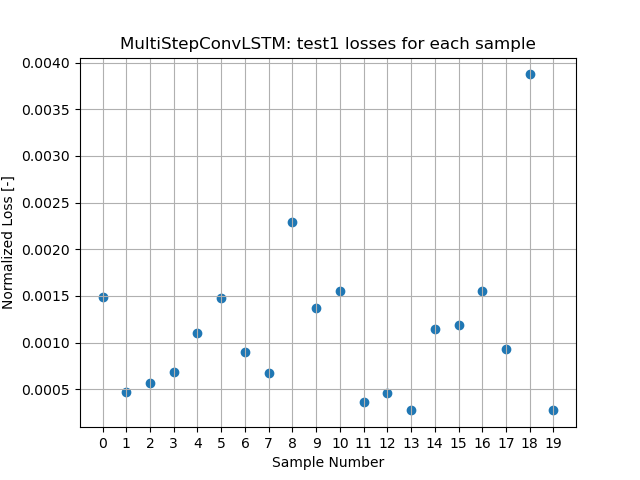

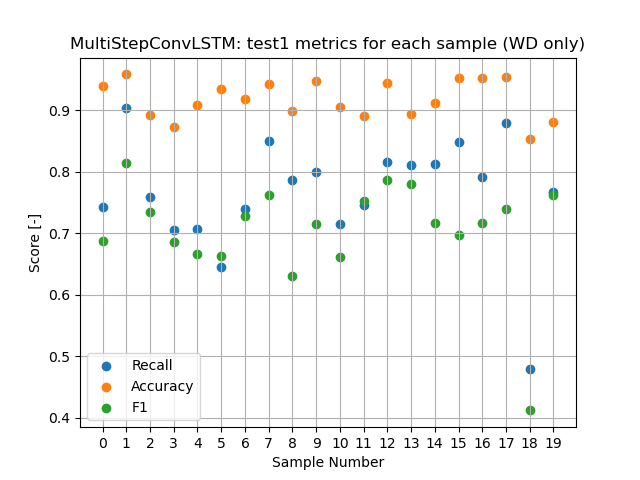

In [20]:
dataset_to_plot = norm_test1
identif = test1

plot_test_loss(dataset_to_plot, model, identif, device)
plot_metrics(dataset_to_plot, model, identif, scaler_y, device)

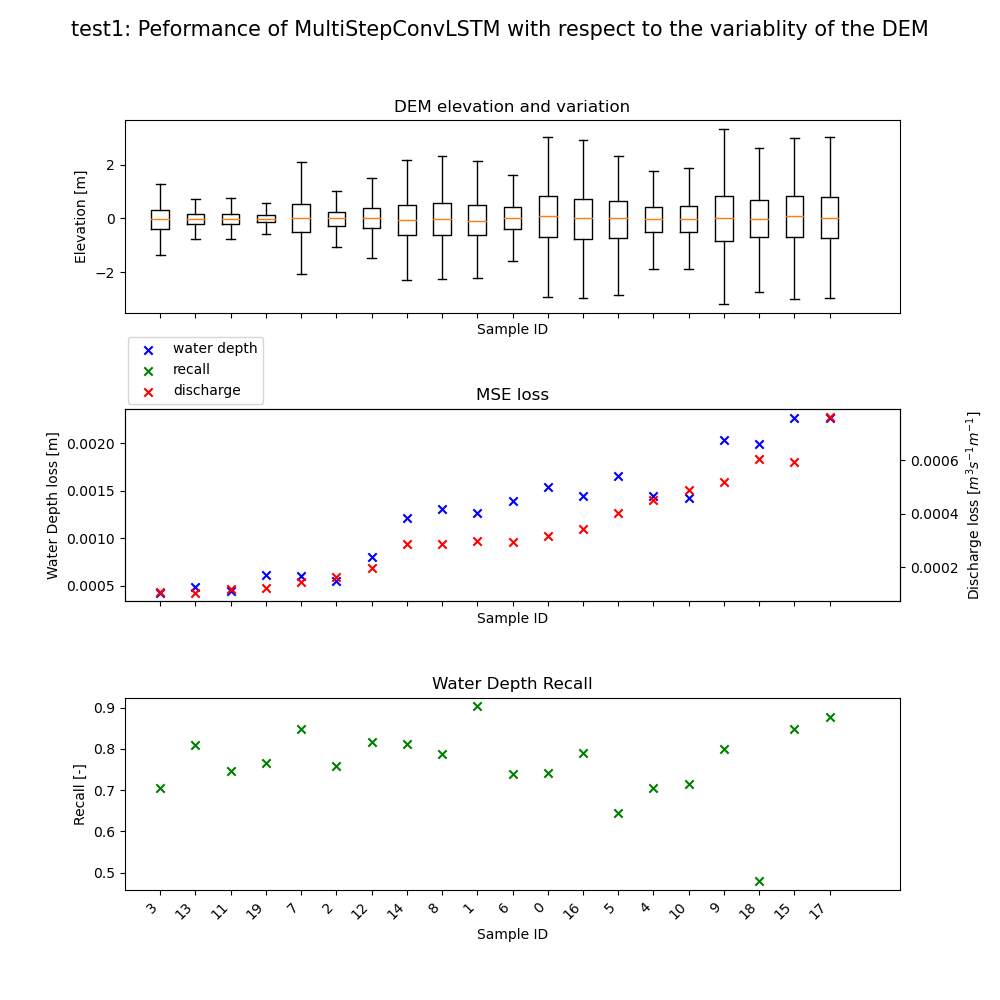

In [21]:
plot_sorted(dataset_to_plot, model, identif, scaler_x, scaler_y, device)

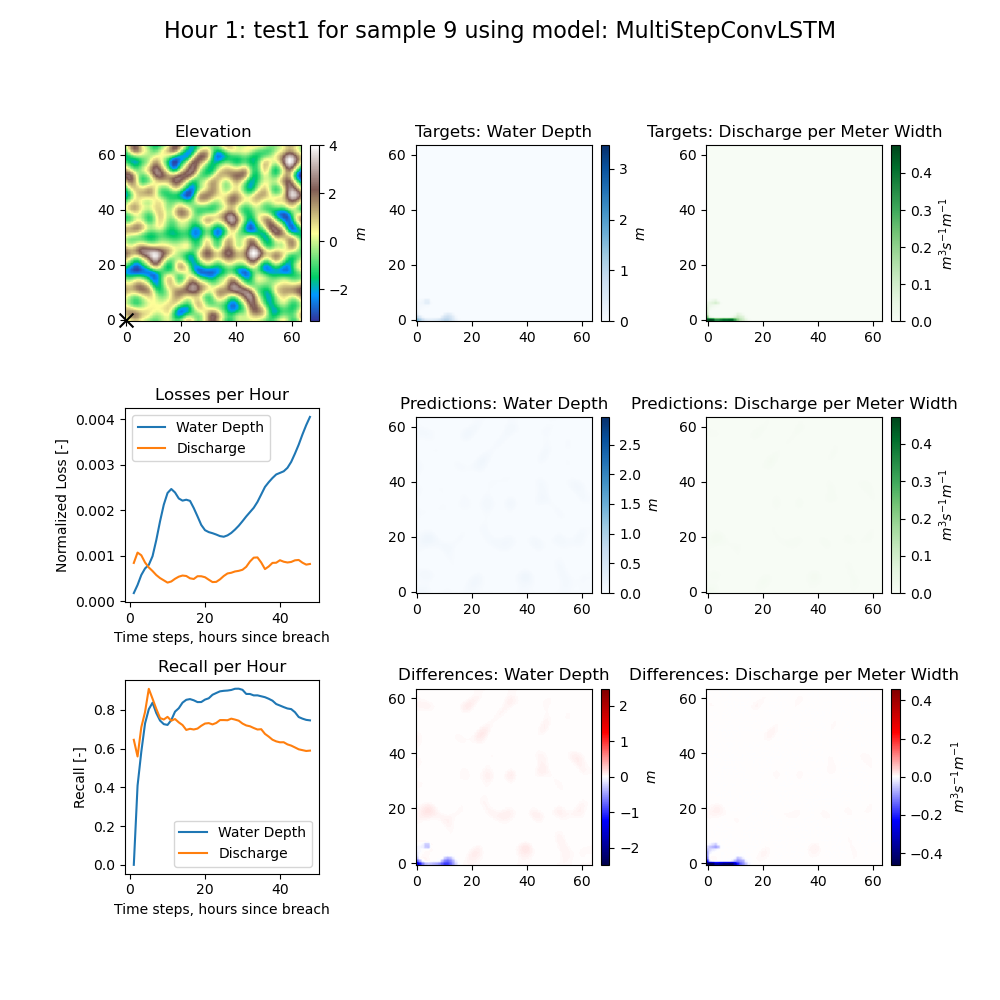

In [22]:
plot_animation(9, norm_test1, model, test1, scaler_x, scaler_y, device = device, save = False)